# Ensemble Methods

This notebook is the hands-on portion of my [talk on ensemble methods](https://github.com/JeffMacaluso/Talks/blob/master/EnsembleMethods/EnsembleMethods.pptx). If you did not attend that talk and are interested in going through this notebook, I'll make a modified version with more commentary for a blog post and link that here when it's available.

**TODO: Add link to blog post**

## Overview

In this notebook, we'll train a few ensemble models on an artificial dataset for binary classification. We'll use scikit-learn to compare a few different types of ensemble methods, and then use XGBoost and LightGBM for more specialized implementations of gradient boosting. Additionally, we'll go over hyperparameter tuning and discuss a few strategies for tuning ensemble models.

One important note here is that we likely won't converge on optimal hyperparameters in this notebook due to the time restrictions of the hands-on portion of the talk. However, the longer blog post version will.

## Setup

The setup here is largely a series of import statements, creating an artificial classification dataset with [scikit-learn's make_classification function](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html), and then creating a function to train our models and gather various metrics.

In [3]:
import sys
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics

print(time.strftime('%Y/%m/%d %H:%M'))
print('OS:', sys.platform)
print('Python:', sys.version)
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)

%matplotlib inline

2018/07/05 18:06
OS: win32
Python: 3.5.5 | packaged by conda-forge | (default, Apr  6 2018, 16:03:44) [MSC v.1900 64 bit (AMD64)]
NumPy: 1.12.1
Pandas: 0.23.1


Creating an artificial data set with [scikit-learn's make_classification function](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).

**Note: The dataset is being kept small to keep within time limits for the talk, but increase the size or swap it out with a real-world dataset to get a better idea of how these algorithms compare under different scenarios**

In [4]:
# Creating an artificial dataset to test algorithms on
data = datasets.make_classification(n_samples=5000,
                                    n_classes=2,
                                    n_features=10,
                                    n_redundant=5,  # Superfluous features working as noise for the algorithms
                                    flip_y=0.5,  # Introduces additional noise
                                    random_state=46)

# Assigning features/labels to variables for ease of use
X = data[0]  # Features
y = data[1]  # Label

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=46)

# Putting into a dataframe for viewing
df = pd.DataFrame(X)
df['label'] = y

df.head()

,0,1,2,3,4,5,6,7,8,9,label
0,-1.609606,-0.405804,1.646726,-1.350422,1.028112,0.150770,0.628511,1.589373,-0.470484,-1.568524,1
1,1.422521,1.471273,-2.185650,-0.368431,-1.657457,0.528370,-1.002433,-1.864973,-1.004933,1.438955,1
2,0.908927,-0.049227,0.826947,-0.195883,1.220820,-1.676695,0.720308,0.209854,0.561905,0.758860,1
3,-0.563904,1.131092,-1.771599,-0.056129,-2.047874,2.180386,-1.217147,-0.923479,0.660668,-0.379916,1
4,1.353001,1.391851,-1.782492,0.991630,-1.272597,0.234084,-0.772074,-1.587041,-0.552018,1.347231,0


In order to adhere to [DRY typing](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself), we'll create a function to train our models and gather the accuracy, [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve), [log loss](https://en.wikipedia.org/wiki/Cross_entropy), and model training time.

In [5]:
# Data frame for gathering results 
results = pd.DataFrame(columns=['Accuracy', 'LogLoss', 'AUC', 'TrainingTime'])
tuned_results = results.copy()

# Function for training a model and retrieving the results
def train_model_get_results(model, model_name):
    '''
    Trains a model and appends the results to the results dataframe
    
    Input:
        - model: The model with specified hyperparameters to be trained
        - model_name: The name of the model to be used as the index
        - is_tuned: A binary flag for if hyperparameter tuning has been performed
    
    Output: The results dataframe with the model results added
    
    Note: Only works with scikit-learn models and frameworks that integrate 
          with the scikit-learn API
    '''
    
    # Collecting training time for results
    start_time = time.time()
    
    print('Training the model')
    model.fit(X_train, y_train)
    
    end_time = time.time()
    total_training_time = end_time - start_time
    print('Completed')
    
    # Calculating the testing set accuracy with the score method
    accuracy = model.score(X_test, y_test)
    
    # Calcuating the AUC and log loss with predicted probabilities
    class_probabilities = model.predict_proba(X_test)
    log_loss = metrics.log_loss(y_test, class_probabilities)
    auc = metrics.roc_auc_score(y_test, class_probabilities[:, 1])
    
    # Adding the model results to the results dataframe
    model_results = [accuracy, log_loss, auc, total_training_time]
    results.loc[model_name] = model_results
    
    print('\n', 'Non-tuned results:')
    return results

## Baseline

It's always useful to have a baseline to compare against and let us know generally how difficult a problem is going to be. I like to use linear or logistic regression due to each them being extremely fast to train.

In [72]:
# Instantiating the model
logistic_regression = linear_model.LogisticRegression()

# Using our user defined function to train the model and return the results
train_model_get_results(model=logistic_regression, model_name='Logistic Regression')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604543,0.743498,0.015480
Random Forest,0.652667,1.368431,0.697158,0.187487
Gradient Boosted Trees,0.723333,0.596458,0.733282,0.703082
Stacking,0.672000,1.218075,0.699401,1.203035
LightGBM,0.722667,0.600648,0.734010,0.062514
XGBoost,0.722000,0.595399,0.736951,0.515595


## Bagging

Bagging (bootstrap aggregating) is the technique that aggregates models built with bootstrapping, or sampling with replacement, via a majority vote or by averaging the predictions. The trees are independent of each other and can be built in parallel. 

Bagging models tend to decrease variance.

### Random Forest

The most popular bagging algorithm is the **random forest**. This algorithm works by building a series of decision trees where each tree uses a random selection of variables, and then decision trees vote on the final answer.  

More specifically, for each tree:

- Use a different training sample with replacement (bootstrapping) for the data
- For each node, choose a number of random attributes and find the best split
- Typically is not pruned in order to have a smaller bias

Once these trees are grown, a majority vote among all of the trees will be used to make predictions.

The main ideas here are that the randomness makes a set of diverse models that helps improve accuracy and using random subsets of features to consider at each split helps make it more efficient to train.

<img src="http://www.globalsoftwaresupport.com/wp-content/uploads/2018/02/ggff5544hh.png" width="1000px">

**Advantages:**
- Robustness against over-fitting
    - Since the model is created through dense randomness, the generalization is typically better, and you can usually increase the accuracy with the number of trees up until a saturation point
- Able to parallelize training multiple trees at once and thus speed up training time

In [7]:
random_forest = ensemble.RandomForestClassifier(n_jobs=-1)  # n_jobs=-1 uses all available cores

train_model_get_results(random_forest, model_name='Random Forest')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604543,0.743498,0.015624
Random Forest,0.652667,1.368431,0.697158,0.187487


## Boosting

Boosting methods train a sequence of weak learners (a learner that is barely better than random chance) where each successive model focuses on the parts that the previous model got wrong. The trees have to be built in a sequence and generally cannot be built in parallel without clever tricks.

Boosting models tend to decrease bias.

### Gradient Boosting

While there are a few different boosting algorithms, gradient boosting is arguably the most popular. It's main differentiation from the others is that it uses gradient descent to decide what to focus on in order to minimize loss for the new trees being built in the sequence. This typically gives it performance advantages over other boosting algorithms.

<img src="https://littleml.files.wordpress.com/2017/03/boosted-trees-process.png">

*Source: [BigML](https://blog.bigml.com/2017/03/14/introduction-to-boosted-trees/)*

**Advantages:**
- Can often outperform random forests when properly tuned

**Disadvantages:**
- Typically overfits easier than bagging
- Sensitive to noise & extreme values
- Has to be built sequentially, so cannot parallelize without tricks

In [8]:
gradient_boosting = ensemble.GradientBoostingClassifier()

train_model_get_results(gradient_boosting, model_name='Gradient Boosted Trees')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604543,0.743498,0.015624
Random Forest,0.652667,1.368431,0.697158,0.187487
Gradient Boosted Trees,0.723333,0.596458,0.733282,0.703082


### Note on interpretability

It's possible to obtain "feature importance" from both bagging and boosting methods. These are not as interpretable as coefficients from linear/logistic regressions, but can still give us an idea of what is happening. 

Note that the multicollinearity assumption applies here - these interpretations will be misleading if the features are heavily correlated with each other.

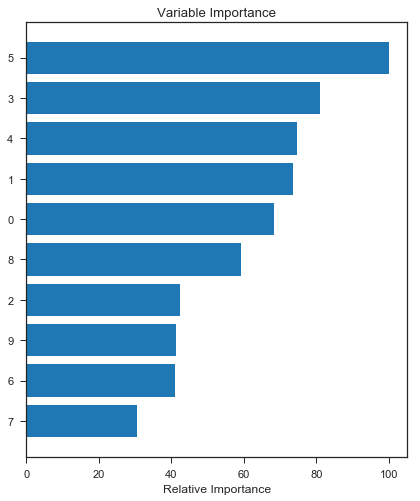

In [9]:
def feature_importance(model):
    '''
    Plots the feature importance for an ensemble model from scikit-learn
    '''
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, sorted_idx)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    

feature_importance(gradient_boosting)

## Stacking

Stacking is the final ensemble technique where we combine several different models into a chain of sorts. It is structured similarly to a neural network where layers of models provide predictions that the next layer then uses as inputs. Ultimately, the meta-classifier creates a final prediction.

<img src="https://qph.fs.quoracdn.net/main-qimg-b22447659f3f63822bc97ba3eff8a546-c">
*Source: [Anshul Joshi](https://www.quora.com/What-is-stacking-in-machine-learning)*

This is a little more nuanced than blending models (averaging their predictions for a final prediction) as the meta-learner learns how useful each of the models are.

**Advantages:**
- Can be more performant when properly tuned

**Disadvantages:**
- Much more computationally costly
- More difficult to tune
- Complete loss of interpretability

We'll need another function that is similar to our previous one for training the models and getting the results. In this case, we'll deal with one layer of classifiers and use a logistic regression for the meta-learner. We'll use five different algorithms for the first layer, but this function is designed to accept any number of models.

In [58]:
def train_stacking_get_results(list_of_models):
    '''
    Trains a stacking classifier and appends the results to the rsults dataframe
    
    Input: list_of_models: a list of untrained scikit-learn models
    
    Output: The results dataframe with the model results added
    
    Note: Only works with scikit-learn models and frameworks that integrate 
          with the scikit-learn API
    '''
    # The meta learner is the one that takes the outputs from
    # the other models as input before final classification
    meta_learner = linear_model.LogisticRegression()

    # Collecting training time for results
    start_time = time.time()
    print('Training the model')

    # Fitting the first layer models
    for model in list_of_models:
        model.fit(X_train, y_train)

    # Collecting the predictions from the models for training
    model_output = []

    for model in list_of_models:
        class_probabilities = model.predict_proba(X_train)[:, 1]
        model_output.append(class_probabilities)

    # Re-shaping before passing to the meta learner
    X_train_meta = np.array(model_output).transpose()

    # Fitting the meta learner
    meta_learner.fit(X_train_meta, y_train)

    end_time = time.time()
    total_time = end_time - start_time
    print('Completed')

    # Collecting the predictions from the models for testing
    model_output = []

    for model in list_of_models:
        class_probabilities = model.predict_proba(X_test)[:, 1]
        model_output.append(class_probabilities)

    # Re-shaping before passing to the meta learner
    X_test_meta = np.array(model_output).transpose()

    # Collecting the accuracy from the meta learner
    accuracy = meta_learner.score(X_test_meta, y_test)

    # Calcuating the log loss with predicted probabilities
    class_probabilities = meta_learner.predict_proba(X_test_meta)
    log_loss = metrics.log_loss(y_test, class_probabilities)
    auc = metrics.roc_auc_score(y_test, class_probabilities[:, 1])

    # Printing coefficients of models
    print()
    print('Coefficients for models')
    for i, coef in enumerate(meta_learner.coef_[0]):
        print('Model {0}: {1}'.format( i+1, coef))
    
    model_results = [accuracy, log_loss, auc, total_time]
    results.loc['Stacking'] = model_results

    return results


# Adding extra imports for additional models
from sklearn import neighbors
from sklearn import svm

# Defining the learners for the first layer
model_1 = linear_model.LogisticRegression()
model_2 = ensemble.RandomForestClassifier(n_jobs=-1)
model_3 = ensemble.GradientBoostingClassifier()
model_4 = neighbors.KNeighborsClassifier(n_jobs=-1)
model_5 = svm.SVC(probability=True)

# Putting the models in a list to iterate through in the function
models = [model_1, model_2, model_3, model_4, model_5]

# Running our function to build a stacking model
train_stacking_get_results(models)

Training the model
Completed

Coefficients for models
Model 1: -1.3549518665184568
Model 2: 13.132706075223963
Model 3: 0.17569166711180417
Model 4: 1.1483654245778776
Model 5: -2.950186165211107


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604543,0.743498,0.015624
Random Forest,0.652667,1.368431,0.697158,0.187487
Gradient Boosted Trees,0.723333,0.596458,0.733282,0.703082
Stacking,0.647333,1.070729,0.678243,4.687212
LightGBM,0.722667,0.600648,0.734010,0.062514
XGBoost,0.722000,0.595399,0.736951,0.515595


# Hyperparameter Tuning

There two main methodologies for hyperparameter tuning: 
1. Manually testing hypotheses on how changing certain hyperparameters will impact the performance of the model
2. Automatically checking a bunch of different combinations of hyperparameters using either a grid search or a randomized search

For this talk, we will discuss a few strategies for the first option, and then go with the second option by using a randomized search. We unfortunately won't have enough time to explore these strategies in this notebook, but the blog post version I mentioned will include that. **TODO: Add link to blog post**

Between grid search and random search, grid search generally makes more intuitive sense. However, research from [James Bergstra and Yoshua Bengio](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf) have shown that random search tends to converge to good hyperparameters faster than grid search. Here's a graphic from their paper that gives an intuitive example of how random search can potentially cover more ground when there are hyperparameters that aren't as important:

<img src="https://cdn-images-1.medium.com/max/923/1*ZTlQm_WRcrNqL-nLnx6GJA.png">

*Source: [James Bergstra & Yoshua Bengio](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)*

## Hyperparameters & Decision Tree Structure

Because both random forests and gradient boosted trees use decision trees for their underlying structures, their hyperparameters are largely the same. Here's a recap of the decision tree structure and a quick summary of what each of the hyperparameters we'll be tuning are:

<img src="http://3.bp.blogspot.com/-2OYbpGM5AsA/T9_UacNCyxI/AAAAAAAAADI/KWb2PJamTVU/s400/1.png">

*Source: [Murtuza Morbiwala](http://insightfromdata.blogspot.com/2012/06/decision-tree-unembellished.html)*


### Hyperparameters

This is list is not all-inclusive, but has most of the common hyperparameters:

- **Number of Estimators:** The number of decision trees to be trained
    - A higher number typically means better predictions (at the cost of computational power) up until a saturation point where the model begins to overfit
- **Max Depth:** How deep a tree can be
    - This should ideally be low for gradient boosting and large (or none) for random forests
- **Minimum Samples per Split:** The minimum samples considered to split a node
    - A higher number typically results in better performance at the cost of computational efficiency
- **Minimum Samples per Leaf:** The minimum number of samples required to be a leaf node
    - A lower number could potentially result in more noise being captured
- **Max Features:** The number of features to consider when looking for the best split
    - A lower number typically reduces variance/increases bias and improves computational efficiency
- **Max Leaf Nodes:** The maximum number of leaf nodes for the tree
    - A smaller number could help prevent overfitting
- **Learning Rate (gradient boosting only):** The adjustment/step size for each iteration
    - A larger step size can help get better performance in fewer iterations, but will plateau at a lower performance
    - A smaller step size will require more iterations (number of estimators) but will ultimately achieve a better performance

Here is an illustration on what a learning rate is and how too small or large of a learning rate can have adverse impacts:

<img src="https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png" width="900px">
*Source: [Jeremy Jordan](https://www.jeremyjordan.me/nn-learning-rate/)*

Here is a more visual version of these hyperparameters on a tree: 

<img src="https://www.analyticsvidhya.com/wp-content/uploads/2016/02/tree-infographic.png">
*Source: [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)*

### General Strategies

Most strategies are specific to either random forests or gradient boosting, but there are a few strategies that apply to both.

- Increase the number of estimators until either just before overfitting begins to start occurring or there are severely diminishing returns in performance
    - Compare the performance against the default parameters to see if this helps and how much
- Further adjust the model complexity (starting with tree depth)
    - Decrease the complexity of the trees if you suspect the model is suffering from high variance
    - Increase the complexity of the trees if you suspect the model is suffering from high bias
    
Remember that hyperparameter tuning is all about controlling model complexity in order to achieve the optimal state in the bias-variance tradeoff:

<img src="https://www.learnopencv.com/wp-content/uploads/2017/02/Bias-Variance-Tradeoff-In-Machine-Learning-1.png" width="600px">
*Source: [Satya Mallick](https://www.learnopencv.com/bias-variance-tradeoff-in-machine-learning/)*

### Setup

In order to do the actual hyperparameter tuning we need to create our third and final function. This will take a model, a dictionary of parameters, perform a random search for the number of iterations, and then give us our results.

In [11]:
def hyperparameter_tune_get_results(model, parameters, model_name, num_rounds=30):
    '''
    Performs a random search to find optimal hyperparameters and append the results
    to the tuned_results dataframe
    
    Input: 
        - model: A scikit-learn model
        - parameters: A dictionary of parameters for the model
        - model_name: A string of the model name for the tuned_results dataframe
        - num_rounds: The number of rounds to try different hyperparameters
    
    Output: The tuned_results dataframe with the results appended
    '''
    
    # Reporting the default parameters before tuning
    print('Default Parameters:', '\n')
    print(model, '\n')
    
    # Defining the random search cross validation
    random_search = RandomizedSearchCV(model,
                                       param_distributions=parameters,
                                       n_iter=num_rounds, n_jobs=-1,, k=3
                                       return_train_score=True, random_state=46,
                                       verbose=20)  # Prints status of each completed fit
    
    print('Beginning hyperparameter tuning')
    start_time = time.time()
    random_search.fit(X_train, y_train)
    end_time = time.time()
    total_training_time = end_time - start_time
    print('Completed')
    
    # Calculating the testing set accuracy on the best estimator with the score method
    accuracy = random_search.best_estimator_.score(X_test, y_test)
    
    # Calcuating the log loss with predicted probabilities
    class_probabilities = random_search.best_estimator_.predict_proba(X_test)
    log_loss = metrics.log_loss(y_test, class_probabilities)
    auc = metrics.roc_auc_score(y_test, class_probabilities[:, 1])
    
    # Adding the model results to the results dataframe
    model_results = [accuracy, log_loss, auc, total_training_time]
    tuned_results.loc[model_name] = model_results
    
    # Plotting the mean training accuracy from the different iterations
    sns.distplot(random_search.cv_results_['mean_test_score'])
    plt.title('Mean test score')
    
    print('Best estimator:', '\n')
    print(random_search.best_estimator_)
    
    print()
    print('Accuracy before tuning:', results.loc[model_name]['Accuracy'])
    print('Accuracy after tuning:', tuned_results.loc[model_name]['Accuracy'])
    
    print('\n', 'Tuned results:')
    return tuned_results

## Baseline

For our logistic regression model, we're just going to tune the regularization parameter. One of the advantages of simpler models like this is that they are easier to tune because we don't have nearly as many hyperparameters to worry about.

**Note: The number of rounds is being kept small in these examples to keep within time limits for the talk, but increase them in a real-world scenario for more effective hyperparameter tuning**

Default Parameters: 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Beginning hyperparameter tuning
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:    3.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    3.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:    3.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    3.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:    3.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-

Completed
Best estimator: 

LogisticRegression(C=0.42865448352263913, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Accuracy before tuning: 0.696
Accuracy after tuning: 0.696

 Tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604582,0.743402,4.015380
Random Forest,0.716000,0.600219,0.733651,66.686641
Gradient Boosted Trees,0.688667,0.733814,0.720964,117.336644
XGBoost,0.722667,0.599443,0.736543,39.794482
LightGBM,0.704667,0.638026,0.726888,53.246779


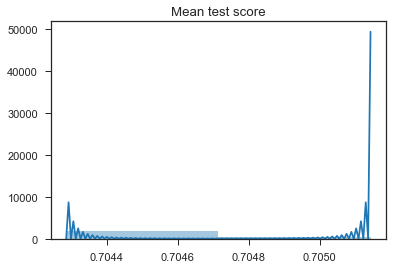

In [60]:
parameters = {'C': scipy.stats.uniform(0, 10),  # Uniform distribution between 0 and 10
              'penalty': ['l1', 'l2']
             }

hyperparameter_tune_get_results(model=logistic_regression, parameters=parameters,
                                model_name='Logistic Regression', num_rounds=5)

## Random Forests

Because random forests are generally robust to overfitting and there aren't as many parameters to control as there are in gradient boosting, our hyperparameter tuning strategy doesn't have to be as nuanced.

I've found that increasing the number of trees has the most direct impact on performance. Because the saturation point of overfitting by too many trees is relatively high for random forests, we can usually increase them until our models take too long to train or there isn't much of a performance gain from using more trees. Scikit-learn's random forest implementation only uses 10 by default, but R's [randomForest](https://cran.r-project.org/web/packages/randomForest/randomForest.pdf#page=17) package uses 500 by default.

That's the first level of complexity to control, so after that it's looking into controlling the max depth for overall model complexity. How this is adjusted depends on if we need to reduce bias or variance.

We can also control a few other components like the number of features considered for each split or the minimum samples required for each split/leaf, but these may not have as large of an impact as the number of estimators or max depth.

Default Parameters: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Beginning hyperparameter tuning
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:   51.4s remaining:   34.2s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   52.6s remaining:   26.3s
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:   55.1s remaining:   20.0s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   59.6s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:  1.0min remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-

Completed
Best estimator: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=452, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Accuracy before tuning: 0.652666666667
Accuracy after tuning: 0.716

 Tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696,0.604539,0.743500,4.859082
Random Forest,0.716,0.600219,0.733651,66.686641


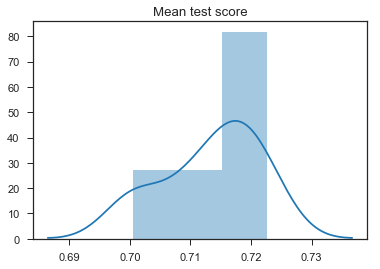

In [13]:
# Creating the dictionary of parameters to use in the search
parameters = {'n_estimators': scipy.stats.randint(low=10, high=500),  # Uniform distribution between 10 and 500
              'max_depth': [None, 10, 30, 100],  # Maximum number of levels in a tree
              'max_features': ['auto', 'log2', None],  # Number of features to consider at each split
              'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
              'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
             }

hyperparameter_tune_get_results(random_forest, parameters, 'Random Forest', num_rounds=5)

## Gradient Boosted Trees

Because gradient boosting is used for kaggle-style competitions more commonly than random forests, there are quite a few more established strategies out there. These models can often be more difficult to tune than random forests, but it is a little more nuanced than simply cranking up the number of trees and crossing your fingers.

One crucial hyperparameter that is introduced to gradient boosting is the learning rate. As previously mentioned, this tells us how drastic the adjustments are on our new trees being built. One peculiarity is that learning rates suffer pretty heavily from the [Goldilocks principle](https://en.wikipedia.org/wiki/Goldilocks_principle) - it has to be just right to have the optimal performance. It also highly depends on the number of trees we're training. Here is a chart that shows the relationship between the number of trees and the learning rate:

<img src="https://cdn-images-1.medium.com/max/923/0*bK0tJrr8dBqCZDmF." width="600px">
*Source: [Synced](https://medium.com/syncedreview/tree-boosting-with-xgboost-why-does-xgboost-win-every-machine-learning-competition-ca8034c0b283)*

Generally speaking, if we have a low number of trees and a high learning rate, we will get to a good performance faster but we will have a lower top-end performance. Conversely, we can get a better performance with a low learning rate and a lot of trees, but it will take much longer to get there.

Most of the other hyperparameters are either similar to or are the same as those in random forests. However, we'll want to use different value ranges for them because the trees between the two algorithms are inherently different. Random forests use larger, relatively unconstrained trees, but boosting methods use weak learners. These week learners are by definition much less complex, so they are smaller, simpler trees.

There are a variety of tuning guides (several are listed [here](https://machinelearningmastery.com/configure-gradient-boosting-algorithm/)), but my favorite is this guide from Zhonghua Zhang, the former \#1 Kaggler in the world:

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/07/Owen-Zhang-Table-of-Suggestions-for-Hyperparameter-Tuning-of-XGBoost.png">
*Source: [Zhonghua Zhang](https://www.slideshare.net/ShangxuanZhang/winning-data-science-competitions-presented-by-owen-zhang)*

Note that this does include several hyperparameters specifically for XGBoost that are not included in the scikit-learn implementation, but we will ignore those for now.

**TODO: Adjust these hyperparameter ranges**

Default Parameters: 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False) 

Beginning hyperparameter tuning
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:   46.6s remaining:   31.1s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   51.7s remaining:   25.8s
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:   57.4s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.1min remaining:   15.9s
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:  1.6min remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-

Completed
Best estimator: 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=542,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Accuracy before tuning: 0.723333333333
Accuracy after tuning: 0.688666666667

 Tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604539,0.743500,4.859082
Random Forest,0.716000,0.600219,0.733651,66.686641
Gradient Boosted Trees,0.688667,0.733814,0.720964,117.336644


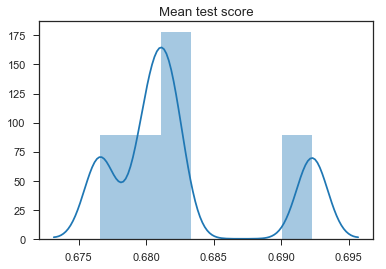

In [16]:
# Creating the dictionary of parameters to use in the search
parameters = {'n_estimators': scipy.stats.randint(low=100, high=1000),  # Uniform distribution between 100 and 1000
              'learning_rate': [0.01, 0.03, 0.1, 0.3],  # How drastic updates are
              'max_depth': [None, 10, 30, 100],  # Maximum number of levels in a tree
              'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
              'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
             }

hyperparameter_tune_get_results(gradient_boosting, parameters, 'Gradient Boosted Trees', num_rounds=5)

## Stacking

Stacking is more of a special case because we have to worry about tuning the hyperparameters of the individual models within the ensemble. 

Due to the time restrictions of this talk, we will be skipping hyperparameter tuning our stacking model. However, this will be done in the blog post mentioned at the beginning of this notebook.

**TODO: Add link to blog post**

# Additional Frameworks

We have been using scikit-learn up until now for our models, but there are more specialized frameworks for gradient boosting in particular. Scikit-learn's gradient boosting algorithm is good, but lacks additional optimization and a few components and options that can be useful

Specifically, we're going to focus on **XGBoost** and **LightGBM**. We'll go into more specifics for each, but both frameworks are focused on speed and performance and have the following advantages & disadvantages:

#### Advantages
- Ability to parallelize training
- Ability to use GPUs
- Additional under-the-hood optimization
- Can specify loss functions
- Additional tuning parameters
- Distributed computing options
- Native handling of missing values

#### Disadvantages
- Relatively difficult to install
- Not as unified integration in older versions

So generally speaking, XGBoost and LightGBM are able to train better models faster, but can be more difficult to set up and use.

### XGBoost

[XGBoost](https://github.com/dmlc/xgboost) is an extremely popular framework for gradient boosted trees created by Tianqi Chen, a Ph.D. student at the University of Washington. It was initially released in 2014, but did not become popular until it started dominating competitions on Kaggle a few years later. It has implementations in several languages, but we will be focusing on the Python implementation. For more history, Tianqi posted [this blog post](https://homes.cs.washington.edu/~tqchen/2016/03/10/story-and-lessons-behind-the-evolution-of-xgboost.html) about the history, philosophy, and learnings behind creating XGBoost.

As I mentioned, both XGBoost and LightGBM use a series of clever tricks and under-the-hood optimizations that are not included in the Scikit-Learn implementation that make them train better models faster. One example is that XGBoost uses second derivatives to find the optimal constant in each terminal node, whereas other implementations just use the first derivative. This is nearly impossible to unpack without getting into the math, but it should give an idea of the type of under-the-hood optimization that is happening. If you are interested, [here is the XGBoost white paper](https://arxiv.org/abs/1603.02754) that explains a lot of the optimizations.

#### Installation

The [installation guide](https://xgboost.readthedocs.io/en/latest/build.html) states that there is only a wheel file on PyPI for the 64-bit version of Linux, so things get a little more complicated for Windows & OSX users. Specifically, you have to build the library from the source.

However, I do have a workaround for Windows users (sorry OSX users!) that I borrowed from [this blog post](https://medium.com/@rakshithvasudev/how-i-installed-xgboost-after-a-lot-of-hassels-on-my-windows-machine-c53e972e801e). Download the wheel file for your version of Windows and Python [here](https://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost) (cp27/35/36/37 are the version of Python, and win32/\_amd64 are the versions of Windows), navigate a command window to the directory where you downloaded it, and do a pip install in your command prompt with `pip install xgboost‑0.72‑cp35‑cp35m‑win_amd64.whl` using whichever wheel file you downloaded.

If you don't know your version of Windows or Python, run the code block below.

In [21]:
import sys
import platform

print('Python:', sys.version)
print(platform.architecture())

Python: 3.5.5 | packaged by conda-forge | (default, Apr  6 2018, 16:03:44) [MSC v.1900 64 bit (AMD64)]
('64bit', 'WindowsPE')


In [27]:
import xgboost as xgb

xgboost = xgb.XGBClassifier(n_jobs=-1)  # n_jobs=-1 uses all available cores

# Due to the scikit-learn API option, LightGBM works with our function!
train_model_get_results(xgboost, 'XGBoost')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604543,0.743498,0.015624
Random Forest,0.652667,1.368431,0.697158,0.187487
Gradient Boosted Trees,0.723333,0.596458,0.733282,0.703082
Stacking,0.641333,1.046866,0.678531,5.312177
LightGBM,0.722667,0.600648,0.734010,0.062481
XGBoost,0.722000,0.595399,0.736951,0.515595


#### Hyperparameter Tuning

XGBoost has additional hyperparameters that can be tuned - [here is the full list](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster). For the purposes of this demonstration, we'll stick with mostly the same hyperparameters that we used for our previous gradient boosting example.

I mentioned this above, but below is the tuning guide from Zhonghua Zhang, the former \#1 kaggler in the world. Additionally, [here](https://machinelearningmastery.com/configure-gradient-boosting-algorithm/) is the blog post containing other tuning strategies that are primarily focused on XGBoost.

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/07/Owen-Zhang-Table-of-Suggestions-for-Hyperparameter-Tuning-of-XGBoost.png">
*Source: [Zhonghua Zhang](https://www.slideshare.net/ShangxuanZhang/winning-data-science-competitions-presented-by-owen-zhang)*

**TODO: Update these hyperparameters**

Default Parameters: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1) 

Beginning hyperparameter tuning
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:   17.5s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   25.7s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:   26.5s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   26.8s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:   27.8s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   32.1s remaining:    0.0s
[Parallel(n_jobs=-

Completed
Best estimator: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1496,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

Accuracy before tuning: 0.722
Accuracy after tuning: 0.722666666667

 Tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604539,0.743500,4.859082
Random Forest,0.716000,0.600219,0.733651,66.686641
Gradient Boosted Trees,0.688667,0.733814,0.720964,117.336644
XGBoost,0.722667,0.599443,0.736543,39.794482


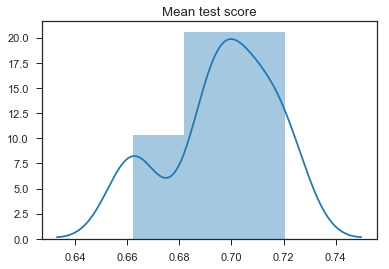

In [30]:
parameters = {'n_estimators': scipy.stats.randint(low=100, high=2000),  # Uniform distribution between 10 and 1000
              'learning_rate': [0.01, 0.03, 0.1, 0.3],
#               'num_leaves': 31,
#               'max_depth': 1,
#               'max_bin': 255,
#               'reg_alpha': 0,  # L1 regularization
#               'reg_lambda': 0  # L2 regularization
             }    

hyperparameter_tune_get_results(xgboost, parameters, 'XGBoost', num_rounds=5)

### LightGBM

[LightGBM](https://github.com/Microsoft/LightGBM) is a project from [Microsoft Research Asia](https://www.microsoft.com/en-us/research/lab/microsoft-research-asia/) that is focused around training gradient boosted trees in a highly efficient and distributed manner. It's generally comparable to XGBoost, but is not as popular because it is much newer. More specifically, LightGBM was released in December, 2016, after XGBoost had taken become the de-facto framework for Kaggle competitions.

One of the fundamental differences between LightGBM and other implementations of gradient boosted trees is that it grows the trees leaf-wise rather than level-wise, which is reportedly able to let them achieve lower loss than level-wise trees:

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/11194110/leaf.png">

<img src="https://raw.githubusercontent.com/Microsoft/LightGBM/master/docs/_static/images/leaf-wise.png">

*Source: [LightGBM](https://github.com/Microsoft/LightGBM/blob/master/docs/Features.rst)*

Additionally, LightGBM uses a histogram based algorithm to discretize continuous variables into buckets in order to speed up the training process and reduce the memory requirements. XGBoost has included this in recent versions, but it is not enabled by default.

There are several other optimizations happening under the hood (listed [here](https://github.com/Microsoft/LightGBM/blob/master/docs/Features.rst)), but those are a few of the main differences from other implementations.

#### Installation

[The documentation on GitHub](https://github.com/Microsoft/LightGBM/tree/master/python-package#installation) has installation instructions for LightGBM. It can be installed from PyPI with `pip install lightgbm`, but requires a few things to work - check out the documentation depending on your OS.

In [34]:
import lightgbm as lgb

lightGBM = lgb.LGBMClassifier(nthread=-1)  # nthread=-1 uses all available cores

# Due to the scikit-learn API option, LightGBM works with our function!
train_model_get_results(lightGBM, 'LightGBM')

Training the model
Completed

 Non-tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604543,0.743498,0.015624
Random Forest,0.652667,1.368431,0.697158,0.187487
Gradient Boosted Trees,0.723333,0.596458,0.733282,0.703082
Stacking,0.641333,1.046866,0.678531,5.312177
LightGBM,0.722667,0.600648,0.734010,0.062514
XGBoost,0.722000,0.595399,0.736951,0.515595


#### Hyperparameter Tuning

Because LightGBM is so similar to XGBoost, we can use the same tuning guidelines in principle. However, there are a few additional tuning guidelines noted in the official [LightGBM Parameter Tuning Guide](http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html).

**TODO: Adjust these hyperparameters**

Default Parameters: 

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1) 

Beginning hyperparameter tuning
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:   28.5s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   34.4s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:   35.9s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   39.2s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:   43.5s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   48.2s remaining:    0.0s
[Parallel(n_jobs=-

Completed
Best estimator: 

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.01,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=1496,
        nthread=-1, num_leaves=31, objective='binary', reg_alpha=0,
        reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

Accuracy before tuning: 0.722666666667
Accuracy after tuning: 0.704666666667

 Tuned results:


,Accuracy,LogLoss,AUC,TrainingTime
Logistic Regression,0.696000,0.604539,0.743500,4.859082
Random Forest,0.716000,0.600219,0.733651,66.686641
Gradient Boosted Trees,0.688667,0.733814,0.720964,117.336644
XGBoost,0.722667,0.599443,0.736543,39.794482
LightGBM,0.704667,0.638026,0.726888,53.246779


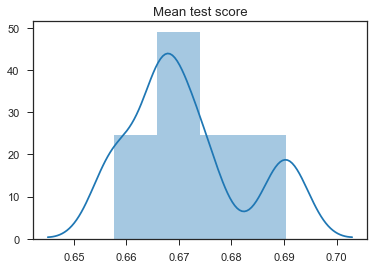

In [37]:
# parameters = {'n_estimators': scipy.stats.randint(low=10, high=500),  # Uniform distribution between 10 and 750
#               'max_features': ['auto', 'sqrt'],  # Number of features to consider at each split
#               'max_depth': [None, 10, 30, 100],  # Maximum number of levels in a tree
#               'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
#               'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
# #               'boostrap': [True, False]
#              }  # If the samples should be bootstrapped or not
             
parameters = {'n_estimators': scipy.stats.randint(low=100, high=2000),  # Uniform distribution between 10 and 1000
              'learning_rate': [0.01, 0.03, 0.1, 0.3],
#               'boosting_type': ['gbdt', 'dart'],
#               'num_leaves': 31,
#               'max_depth': 1,
#               'max_bin': 255,
#               'reg_alpha': 0,  # L1 regularization
#               'reg_lambda': 0  # L2 regularization
             }    

hyperparameter_tune_get_results(lightGBM, parameters, 'LightGBM', num_rounds=5)

# Summary

And there we have it! We looked at different types of ensemble methods, how to tune them, and a few different frameworks for using them.

If you enjoyed that and wanted a more in-depth version where we fully tune our models, check out the blog post when it's released.

**TODO: Add link to blog post**

For a shameless plug, if you liked that kind of material, here are a few places where I put out content:
- [Blog](https://jeffmacaluso.github.io/)
- [GitHub](https://github.com/jeffmacaluso)
- [Twitter](https://twitter.com/MacalusoJeff)
- [Instagram](https://www.instagram.com/booksandtibbs/)
    - Note: This is really just pictures of my dogs, but who doesn't like dogs?